# Evaluating TOC policies with respect to High Resource Areas to increase affordable housing production

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
from sodapy import Socrata
from matplotlib.patches import Ellipse, Polygon

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# getting neighborhood boundaries
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [3]:
neighborhoods = neighborhoods.to_crs(epsg=3857)

# Adding a fire hazard map

In [4]:
fire = gpd.read_file("data/Fire_Hazard_Severity_Zones.geojson")

In [5]:
fire.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
fire.sample(5)

OBJECTID  SRA  HAZ_CODE  HAZ_CLASS INCORP     VH_REC   ShapeSTArea  \
274       275  LRA         3  Very High                    3.199714e+06   
105       106  SRA         3  Very High                    4.217401e+06   
422       423  FRA         3  Very High         Very High  3.530586e+06   
887       888  LRA         3  Very High                    9.199629e+02   
276       277  LRA         3  Very High                    7.089844e-01   

     ShapeSTLength                                           geometry  
274   10677.035082  POLYGON ((-117.84694 34.06249, -117.84712 34.0...  
105   11290.060680  POLYGON ((-118.19378 34.28417, -118.19083 34.2...  
422    7959.256464  POLYGON ((-118.79334 34.78159, -118.78891 34.7...  
887     153.345617  POLYGON ((-118.48045 34.44884, -118.48055 34.4...  
276     523.041084  POLYGON ((-118.72411 34.12824, -118.72411 34.1...

<AxesSubplot: >

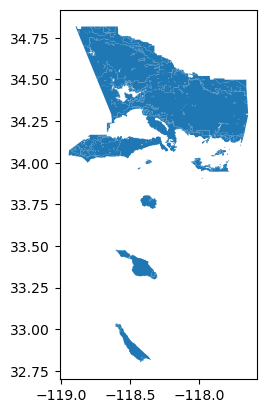

In [7]:
fire.plot()

In [8]:
fire['HAZ_CLASS'].value_counts()

Very High    762
High         118
Moderate      60
Name: HAZ_CLASS, dtype: int64

In [9]:
#trimming data to only keep residential
fire_vh = fire.loc[fire['HAZ_CLASS'].isin(['Very High'])].copy()
fire_vh.sample(5)

OBJECTID  SRA  HAZ_CODE  HAZ_CLASS INCORP     VH_REC   ShapeSTArea  \
289       290  LRA         3  Very High                    3.354317e+05   
504       505  FRA         3  Very High         Very High  3.609445e+06   
332       333  LRA         3  Very High      Y             4.762910e+08   
341       342  LRA         3  Very High         Very High  2.938305e+05   
684       685  LRA         3  Very High                    5.467090e+01   

     ShapeSTLength                                           geometry  
289    3178.184685  POLYGON ((-117.82274 34.15422, -117.82275 34.1...  
504    7910.776642  POLYGON ((-118.24552 34.46346, -118.23707 34.4...  
332  302478.781016  POLYGON ((-118.49871 34.33423, -118.49885 34.3...  
341    3163.318860  MULTIPOLYGON (((-117.94219 34.13105, -117.9425...  
684    1211.796222  POLYGON ((-118.54733 34.35613, -118.54728 34.3...

In [10]:
fire_vh['HAZ_CLASS'].value_counts()

Very High    762
Name: HAZ_CLASS, dtype: int64

In [11]:
# read and add TCAC shapefile to notebook using url
url = "https://www.treasurer.ca.gov/ctcac/opportunity/2023/final_2023_shapefile.zip"
TCAC = gpd.read_file(url)
TCAC.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10136 entries, 0 to 10135
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   fips      10136 non-null  object  
 1   fips_bg   3093 non-null   object  
 2   cnty_nm   10136 non-null  object  
 3   countyd   10136 non-null  object  
 4   region    10136 non-null  object  
 5   ecn_dmn   9747 non-null   float64 
 6   env_hl_   9747 non-null   float64 
 7   ed_domn   9747 non-null   float64 
 8   index     9233 non-null   float64 
 9   oppcat    9747 non-null   object  
 10  geometry  10133 non-null  geometry
dtypes: float64(4), geometry(1), object(6)
memory usage: 871.2+ KB


In [12]:
#showing desired columns of county name, opportunity and geometry
TCAC[['fips','cnty_nm','oppcat','geometry']]

fips  cnty_nm             oppcat  \
0      06001400100  Alameda   Highest Resource   
1      06001400200  Alameda   Highest Resource   
2      06001400300  Alameda      High Resource   
3      06001400400  Alameda      High Resource   
4      06001400500  Alameda      High Resource   
...            ...      ...                ...   
10131  06115041000     Yuba               None   
10132  06115041100     Yuba  Moderate Resource   
10133  06115041100     Yuba   Highest Resource   
10134  06115041100     Yuba  Moderate Resource   
10135  06115041100     Yuba               None   

                                                geometry  
0      POLYGON ((-122.23418 37.85254, -122.23428 37.8...  
1      POLYGON ((-122.25253 37.85110, -122.25094 37.8...  
2      POLYGON ((-122.26417 37.83787, -122.26427 37.8...  
3      POLYGON ((-122.26081 37.84869, -122.26023 37.8...  
4      POLYGON ((-122.26023 37.85274, -122.26081 37.8...  
...                                                  ...  
10131  POLYGON ((-121.63631 39.24941, -121.63581 39.2...  
10132  POLYGON ((-121.27892 39.49773, -121.27724 39.5...  
10133  POLYGON ((-121.32330 39.36354, -121.32129 39.3...  
10134  POLYGON ((-121.28387 39.46216, -121.27864 39.4...  
10135  POLYGON ((-121.37257 39.37358, -121.37048 39.3...  

[10136 rows x 4 columns]

In [13]:
#creating a list of desired columns
desired_columns =['fips','cnty_nm','oppcat','geometry']
desired_columns

['fips', 'cnty_nm', 'oppcat', 'geometry']

In [14]:
#trimming data to the 3 desired columns and creating a new dataset
TCAC_cleared = TCAC[desired_columns].copy()

In [15]:
#trimming to LA city boundary
#importing city boundary file
cityofla = gpd.read_file('data/City_Boundary (1).zip')

In [16]:
#trimming to LA city boundary
citytracts = cityofla.overlay(TCAC_cleared, how='intersection')

In [17]:
#assigning colors to each oppcat category and creating a color column
citytracts.loc[citytracts['oppcat'] == 'Highest Resource', 'color'] = '#93b9c6ff'
citytracts.loc[citytracts['oppcat'] == 'High Resource', 'color'] = '#aed0d9ff'
citytracts.loc[citytracts['oppcat'] == 'Moderate Resource', 'color'] = '#FFFFFF'
citytracts.loc[citytracts['oppcat'] == 'Low Resource', 'color'] = '#FFFFFF'
citytracts.loc[citytracts['oppcat'] == 'High Segregation & Poverty', 'color'] = '#FFFFFF'

In [18]:
#trying to see if oppcat has any NaN values, because of which the map wasn't plotting based on the color column
citytracts['oppcat'].isnull().values.any()


True

In [19]:
#dropping rows with NaN values
citytracts.dropna(subset=['oppcat'], how='all', inplace=True)

In [20]:
citytracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
#for linear calculations, lets project to web mercator
citytracts = citytracts.to_crs(epsg=3857)

In [22]:
#trimming fire data to the city
fire_la = cityofla.overlay(fire_vh, how='intersection')

<AxesSubplot: >

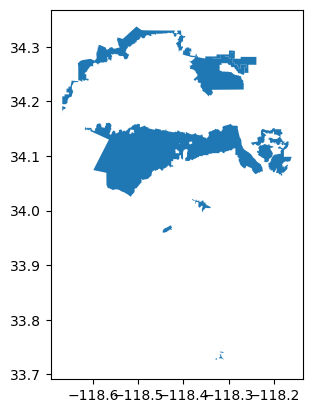

In [23]:
fire_la.plot()

In [24]:
fire_la.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
#changing projection of fire data
fire_la = fire_la.to_crs(epsg=3857)

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


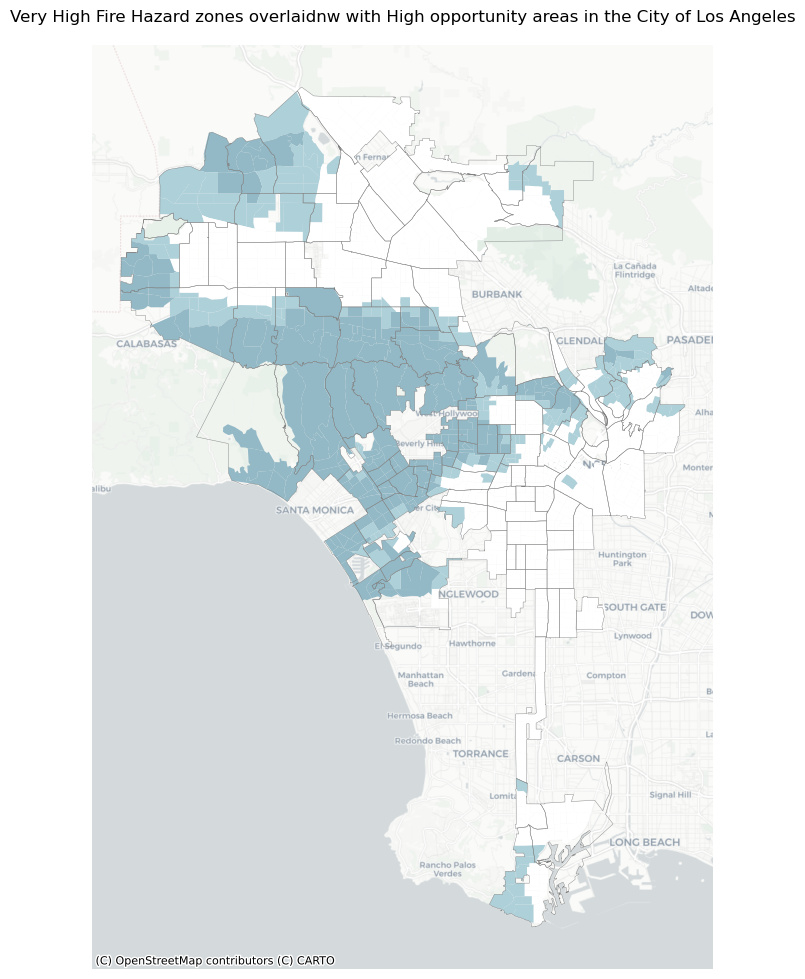

In [26]:
#plotting with assigned colours
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))

#adding colour to the plot
citytracts.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = citytracts['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
             
           
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )


neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.3,
            )
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Very High Fire Hazard zones overlaidnw with High opportunity areas in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [27]:
#to get the area of each oppcat valye, lets dissolve and then calculate 
TCAC_all = citytracts.dissolve(by='oppcat')

In [28]:
TCAC_all.info

<bound method DataFrame.info of                                                                      geometry  \
oppcat                                                                          
High Resource               MULTIPOLYGON (((-13196338.980 4052098.209, -13...   
High Segregation & Poverty  MULTIPOLYGON (((-13167560.258 4008980.363, -13...   
Highest Resource            MULTIPOLYGON (((-13198835.069 4034361.090, -13...   
Low Resource                MULTIPOLYGON (((-13195368.608 4053025.032, -13...   
Moderate Resource           MULTIPOLYGON (((-13185160.773 4028083.734, -13...   

                            OBJECTID CITY         fips      cnty_nm      color  
oppcat                                                                          
High Resource                      1   IN  06037101122  Los Angeles  #aed0d9ff  
High Segregation & Poverty         1   IN  06037104701  Los Angeles    #FFFFFF  
Highest Resource                   1   IN  06037106641  Los Angeles  #93b9c6

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


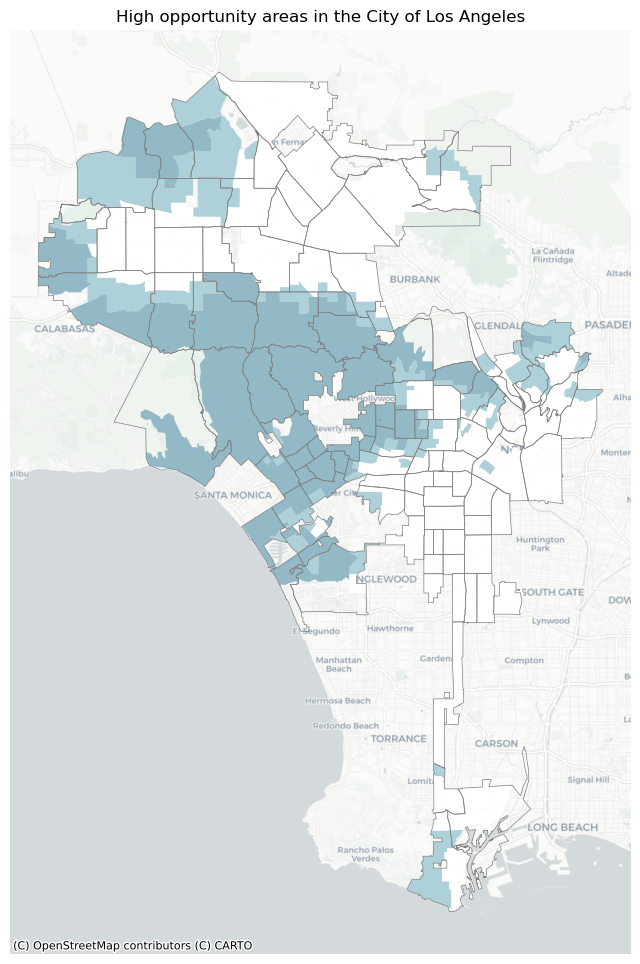

In [29]:
#plotting with assigned colours
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))

#adding colour to the plot
TCAC_all.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = TCAC_all['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
          
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.5,
            )
          
          
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('High opportunity areas in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [30]:
#getting a column to calculate the area of each opportnity category
TCAC_all['area_km2'] = TCAC_all.area / 1000**2

In [31]:
TCAC_all.sample(5)

geometry  \
oppcat                                                                          
Low Resource                MULTIPOLYGON (((-13195368.608 4053025.032, -13...   
Moderate Resource           MULTIPOLYGON (((-13185160.773 4028083.734, -13...   
High Resource               MULTIPOLYGON (((-13196338.980 4052098.209, -13...   
Highest Resource            MULTIPOLYGON (((-13198835.069 4034361.090, -13...   
High Segregation & Poverty  MULTIPOLYGON (((-13167560.258 4008980.363, -13...   

                            OBJECTID CITY         fips      cnty_nm  \
oppcat                                                                
Low Resource                       1   IN  06037104103  Los Angeles   
Moderate Resource                  1   IN  06037101110  Los Angeles   
High Resource                      1   IN  06037101122  Los Angeles   
Highest Resource                   1   IN  06037106641  Los Angeles   
High Segregation & Poverty         1   IN  06037104701  Los Angeles   

                                color    area_km2  
oppcat                                             
Low Resource                  #FFFFFF  336.740797  
Moderate Resource             #FFFFFF  342.448132  
High Resource               #aed0d9ff  273.800812  
Highest Resource            #93b9c6ff  511.743823  
High Segregation & Poverty    #FFFFFF   93.916710

In [32]:
#selecting only high and highest resource areas
TCAC_HH = TCAC_all.loc[TCAC_all['color'].isin(['#93b9c6ff','#aed0d9ff'])].copy()
TCAC_HH.sample(2)

geometry  OBJECTID  \
oppcat                                                                          
Highest Resource  MULTIPOLYGON (((-13198835.069 4034361.090, -13...         1   
High Resource     MULTIPOLYGON (((-13196338.980 4052098.209, -13...         1   

                 CITY         fips      cnty_nm      color    area_km2  
oppcat                                                                  
Highest Resource   IN  06037106641  Los Angeles  #93b9c6ff  511.743823  
High Resource      IN  06037101122  Los Angeles  #aed0d9ff  273.800812

# Zoning data
## Bringing in the zoning data to compare the % of single family zones in high and highest resourse areas

In [33]:
#importing LA city zoning data
sf=gpd.read_file("data/Zoning.shp")

In [34]:
sf.ZONE_SMRY.unique()

array(['INDUSTRIAL', 'RESIDENTIAL', 'AGRICULTURE', 'COMMERCIAL',
       'PARKING', 'PUBLIC FACILITY', 'OPEN SPACE', None], dtype=object)

In [35]:
#trimming data to only keep residential
sf_r = sf.loc[sf['ZONE_SMRY'].isin(['RESIDENTIAL','COMMERCIAL'])].copy()
sf_r.sample(5)

OBJECTID    ZONE_CMPLT ZONE_CLASS    ZONE_SMRY  SHAPE_Leng  \
48451     48452  RE9-1-O-HPOZ        RE9  RESIDENTIAL    0.004173   
28678     28679          R1-1         R1  RESIDENTIAL    0.006131   
9969       9970         C2-1D         C2   COMMERCIAL    0.003180   
34939     34940        R2-1XL         R2  RESIDENTIAL    0.001400   
10836     10837   C2-1VL-CPIO         C2   COMMERCIAL    0.003243   

         SHAPE_Area                                           geometry  
48451  8.580910e-07  POLYGON ((-118.31588 34.04787, -118.31588 34.0...  
28678  9.214503e-07  POLYGON ((-118.53358 34.21920, -118.53358 34.2...  
9969   4.636211e-07  POLYGON ((-118.30065 34.10209, -118.30065 34.1...  
34939  1.220317e-07  POLYGON ((-118.29471 33.72757, -118.29471 33.7...  
10836  5.037088e-07  POLYGON ((-118.28214 33.96698, -118.28252 33.9...

In [36]:
sf_r.ZONE_CLASS.unique()

array(['R2', 'RE11', 'C1', 'C1.5', 'C2', 'RAS4', 'C4', 'CR', 'R1', 'R3',
       'R3P', 'R4', 'R4P', 'R5', 'RD1.5', 'RD2', 'RD3', 'RD6', 'RD4',
       'RD5', 'RS', 'RZ3', 'RZ5', 'RE20', 'RU', 'RE40', 'RE9', 'RAS3',
       'R2P', 'USC-3', 'C5', 'R1P', 'USC-1A', 'RMP', 'RE', 'RZ4', 'ADP',
       'C1(PV)', 'USC-2', 'USC-1B', 'C2(PV)', 'LASED', 'C4(OX)',
       'CR(PKM)', 'CW', 'R1V2', 'R1R3', 'R1H1', 'R1V1', 'R1V3', 'R3(PV)',
       'R4(PV)', 'R5P', 'RE15', 'RSP', 'RW1', 'RW2', 'RZ2.5', 'R3(UV)',
       'RAS3(UV)', 'PPSP', 'PVSP'], dtype=object)

In [38]:
#trimming data to only include zones 5 buildings OR MORE
sf_trimmed = sf.loc[sf['ZONE_CLASS'].isin(['RAS4','R3','R3P','R4','R4P','R5','RD1.5','RD2','RD3','RD6','RD4','RD5','RZ3','RZ5','RAS3','R2P','RMP','RE','R3(PV)','R4(PV)','R5P','RSP','R3(UV)','RAS3(UV)','C1','C1.5','C2','C4','CR','C5','CM'])].copy()

In [39]:
#saving file as csv
sf_trimmed.to_csv('mf_zoning.csv')

In [38]:
sf_trimmed.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
#for linear calculations, lets project to web mercator
sf_trimmed = sf_trimmed.to_crs(epsg=3857)

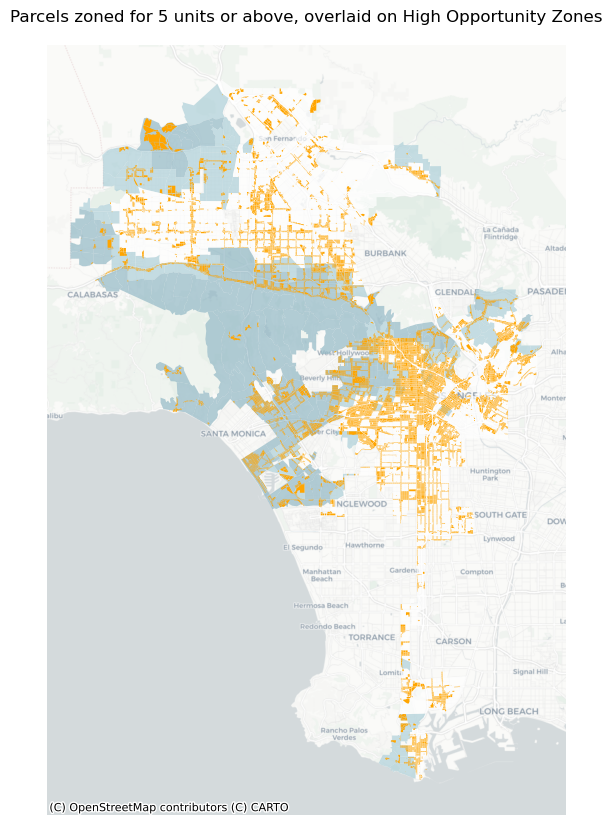

In [74]:
#plotting with neighborhood boundaries
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))


#adding colour to the plot

citytracts.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = citytracts['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
            alpha = 0.7,
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

sf_trimmed.plot(
            ax=ax,   
            column = 'ZONE_SMRY',   # column that defines the color of the dots
            color='orange',
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

          
    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Parcels zoned for 5 units or above, overlaid on High Opportunity Zones')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# TOC data

In [41]:
#importing TOC Tier data
TOC=gpd.read_file("data/TOC_Tiers_Oct2017.shp")

In [42]:
TOC.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FINALTIER   4 non-null      object  
 1   Shape_Leng  4 non-null      float64 
 2   Shape__Are  4 non-null      float64 
 3   Shape__Len  4 non-null      float64 
 4   geometry    4 non-null      geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 288.0+ bytes


In [43]:
TOC.sample(4)

FINALTIER    Shape_Leng    Shape__Are    Shape__Len  \
2         3  1.589041e+06  2.137552e+08  5.851425e+05   
1         1  3.017387e+06  2.755322e+08  1.111673e+06   
3         4  2.353011e+05  1.572433e+07  8.664562e+04   
0         2  2.290647e+06  1.256173e+08  8.437185e+05   

                                            geometry  
2  MULTIPOLYGON (((-13168250.773 3992478.448, -13...  
1  MULTIPOLYGON (((-13167503.363 3995326.042, -13...  
3  MULTIPOLYGON (((-13161936.586 4019354.718, -13...  
0  MULTIPOLYGON (((-13168247.229 3991650.959, -13...

In [44]:
#getting a column to calculate the area of each tier category
TOC['area_km2'] = TOC.area / 1000**2

In [45]:
TOC.sample(4)

FINALTIER    Shape_Leng    Shape__Are    Shape__Len  \
1         1  3.017387e+06  2.755322e+08  1.111673e+06   
3         4  2.353011e+05  1.572433e+07  8.664562e+04   
0         2  2.290647e+06  1.256173e+08  8.437185e+05   
2         3  1.589041e+06  2.137552e+08  5.851425e+05   

                                            geometry    area_km2  
1  MULTIPOLYGON (((-13167503.363 3995326.042, -13...  275.532188  
3  MULTIPOLYGON (((-13161936.586 4019354.718, -13...   15.724326  
0  MULTIPOLYGON (((-13168247.229 3991650.959, -13...  125.617260  
2  MULTIPOLYGON (((-13168250.773 3992478.448, -13...  213.755230

In [46]:
#assigning colors to each tier and creating a color column
TOC.loc[TOC['FINALTIER'] == '4', 'color'] = '#850434ff'
TOC.loc[TOC['FINALTIER'] == '3', 'color'] = '#bc1d59ff'
TOC.loc[TOC['FINALTIER'] == '2', 'color'] = '#e487adff'
TOC.loc[TOC['FINALTIER'] == '1', 'color'] = '#eec8d7ff'


/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

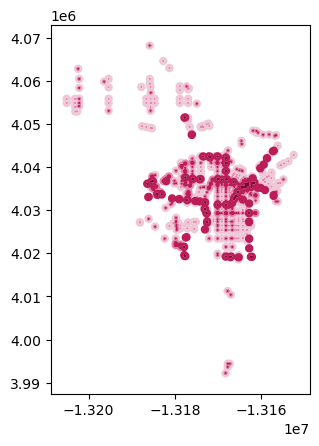

In [47]:
TOC.plot(
              
            column = 'FINALTIER',   # column that defines the color of the dota
            color = TOC['color'], #to color according to the TOC values, based on a new column       
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

In [48]:
TOC.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

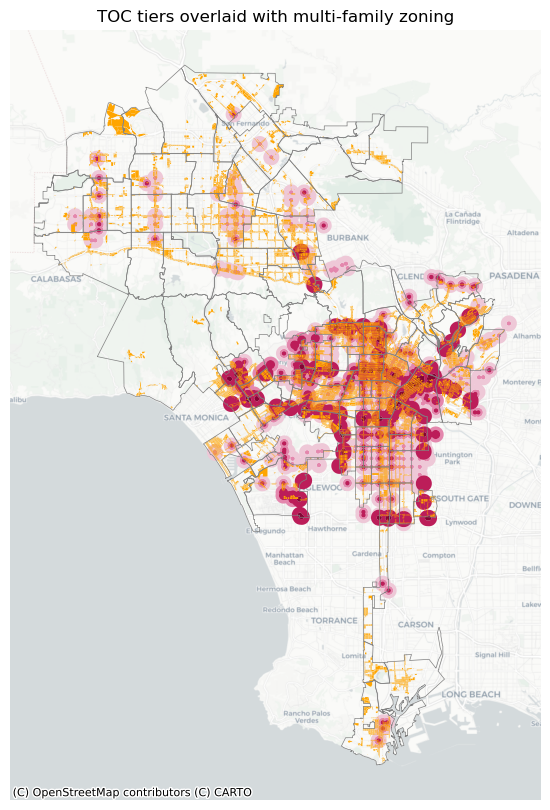

In [73]:
#plotting with neighborhood boundaries
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))



#adding colour to the plot
TOC.plot(
            ax=ax,   
            column = 'FINALTIER',   # column that defines the color of the dota
            color = TOC['color'], #to color according to the TOC values, based on a new column       
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

sf_trimmed.plot(
            ax=ax,   
            column = 'ZONE_SMRY',   # column that defines the color of the dots
            color='orange',
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.5,
            )

    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('TOC tiers overlaid with multi-family zoning')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

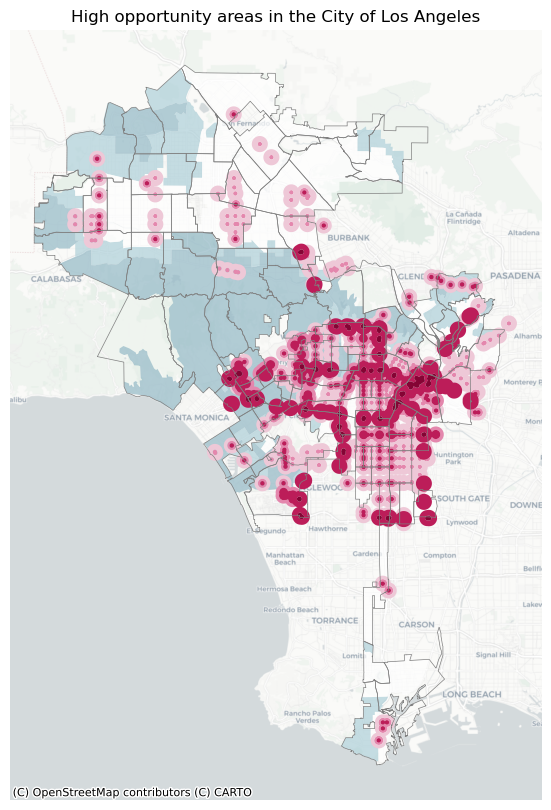

In [50]:
#plotting with high resource neigbhborhoods, and TOC
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))


#adding colour to the plot
TCAC_all.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = TCAC_all['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
            alpha = 0.7,
            
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )  

TOC.plot(
            ax=ax,   
            column = 'FINALTIER',   # column that defines the color of the dota
            color = TOC['color'], #to color according to the TOC values, based on a new column       
            legend = True,     # add a legend        
            alpha = 1,       
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.5,
            )
          
    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('High opportunity areas in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [51]:
#creating a column to help dissolve the data later
TOC.loc[TOC['FINALTIER'] == '1', 'DISSOLVE'] = 'DISSOLVE'
TOC.loc[TOC['FINALTIER'] == '2', 'DISSOLVE'] = 'DISSOLVE'
TOC.loc[TOC['FINALTIER'] == '3', 'DISSOLVE'] = 'DISSOLVE'
TOC.loc[TOC['FINALTIER'] == '4', 'DISSOLVE'] = 'DISSOLVE'
TOC.sample(4)

FINALTIER    Shape_Leng    Shape__Are    Shape__Len  \
3         4  2.353011e+05  1.572433e+07  8.664562e+04   
0         2  2.290647e+06  1.256173e+08  8.437185e+05   
2         3  1.589041e+06  2.137552e+08  5.851425e+05   
1         1  3.017387e+06  2.755322e+08  1.111673e+06   

                                            geometry    area_km2      color  \
3  MULTIPOLYGON (((-13161936.586 4019354.718, -13...   15.724326  #850434ff   
0  MULTIPOLYGON (((-13168247.229 3991650.959, -13...  125.617260  #e487adff   
2  MULTIPOLYGON (((-13168250.773 3992478.448, -13...  213.755230  #bc1d59ff   
1  MULTIPOLYGON (((-13167503.363 3995326.042, -13...  275.532188  #eec8d7ff   

   DISSOLVE  
3  DISSOLVE  
0  DISSOLVE  
2  DISSOLVE  
1  DISSOLVE

In [52]:
#to get the area of each oppcat valye, lets dissolve and then calculate 
TOC_dis = TOC.dissolve(by='DISSOLVE')

In [53]:
TOC_dis.sample()

geometry FINALTIER  \
DISSOLVE                                                                
DISSOLVE  MULTIPOLYGON (((-13187137.275 4027249.950, -13...         2   

            Shape_Leng    Shape__Are     Shape__Len   area_km2      color  
DISSOLVE                                                                   
DISSOLVE  2.290647e+06  1.256173e+08  843718.537556  125.61726  #e487adff

In [54]:
#getting a column to calculate the area of each tier category
TOC_dis['area_km2'] = TOC_dis.area / 1000**2

In [55]:
TOC_dis.sample()

geometry FINALTIER  \
DISSOLVE                                                                
DISSOLVE  MULTIPOLYGON (((-13187137.275 4027249.950, -13...         2   

            Shape_Leng    Shape__Are     Shape__Len    area_km2      color  
DISSOLVE                                                                    
DISSOLVE  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


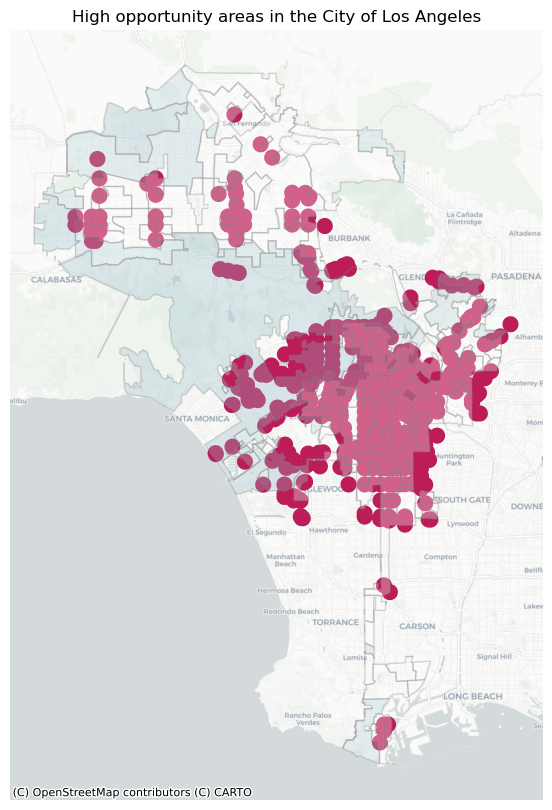

In [56]:
#plotting with high resource neigbhborhoods, and TOC after both have been dissolved
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))


#adding colour to the plot
TOC_dis.plot(
            ax=ax,   
            column = 'FINALTIER',   # column that defines the color of the dota
            color = '#bc1d59ff', #to color according to the TOC values, based on a new column       
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

TCAC_all.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = TCAC_all['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
            alpha = 0.3,
            edgecolor = 'grey',
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            ) 

    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('High opportunity areas in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Extracting area that is under TOC based on opportunity 

In [57]:
#doing a overlay between high resource and TOC data after they have been dissolved
TCAC_TOC = TOC_dis.overlay(TCAC_HH, how='intersection')

In [58]:
TCAC_TOC.sample(2)

FINALTIER    Shape_Leng    Shape__Are     Shape__Len  area_km2_1    color_1  \
1         2  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff   
0         2  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff   

   OBJECTID CITY         fips      cnty_nm    color_2  area_km2_2  \
1         1   IN  06037106641  Los Angeles  #93b9c6ff  511.743823   
0         1   IN  06037101122  Los Angeles  #aed0d9ff  273.800812   

                                            geometry  
1  MULTIPOLYGON (((-13154312.773 4042058.994, -13...  
0  MULTIPOLYGON (((-13156170.579 4041127.136, -13...

In [59]:
#creating a column to help dissolve the data later
TCAC_TOC.loc[TCAC_TOC['fips'] == '06037106641','oppcat'] = 'Highest_Resource'
TCAC_TOC.loc[TCAC_TOC['fips'] == '06037101122','oppcat'] = 'High_Resource'
TCAC_TOC.sample(2)

FINALTIER    Shape_Leng    Shape__Are     Shape__Len  area_km2_1    color_1  \
1         2  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff   
0         2  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff   

   OBJECTID CITY         fips      cnty_nm    color_2  area_km2_2  \
1         1   IN  06037106641  Los Angeles  #93b9c6ff  511.743823   
0         1   IN  06037101122  Los Angeles  #aed0d9ff  273.800812   

                                            geometry            oppcat  
1  MULTIPOLYGON (((-13154312.773 4042058.994, -13...  Highest_Resource  
0  MULTIPOLYGON (((-13156170.579 4041127.136, -13...     High_Resource

In [60]:
#getting a column to calculate the area of each tier category
TCAC_TOC['area_km2_use'] = TCAC_TOC.area / 1000**2

In [61]:
TCAC_TOC.sample(2)

FINALTIER    Shape_Leng    Shape__Are     Shape__Len  area_km2_1    color_1  \
0         2  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff   
1         2  2.290647e+06  1.256173e+08  843718.537556  630.628771  #e487adff   

   OBJECTID CITY         fips      cnty_nm    color_2  area_km2_2  \
0         1   IN  06037101122  Los Angeles  #aed0d9ff  273.800812   
1         1   IN  06037106641  Los Angeles  #93b9c6ff  511.743823   

                                            geometry            oppcat  \
0  MULTIPOLYGON (((-13156170.579 4041127.136, -13...     High_Resource   
1  MULTIPOLYGON (((-13154312.773 4042058.994, -13...  Highest_Resource   

   area_km2_use  
0     66.149035  
1     93.669565

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


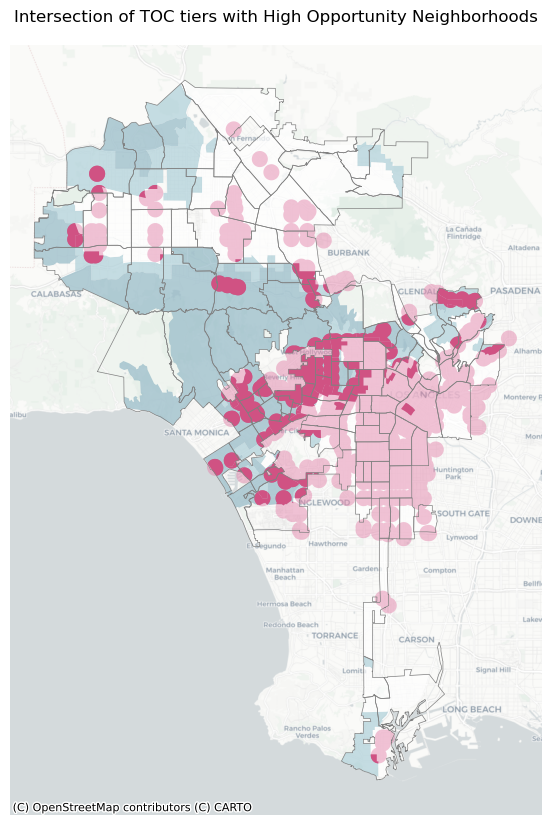

In [62]:
#plotting with high resource neigbhborhoods, and TOC after both have been dissolved
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))


#adding colour to the plot

TCAC_all.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = TCAC_all['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
            alpha = 0.7,
           
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            ) 

TCAC_TOC.plot(
            ax=ax,   
            column = 'FINALTIER',   # column that defines the color of the dota
            color = '#bc1d59ff',        
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )
TOC_dis.plot(
            ax=ax,   
            column = 'FINALTIER',   # column that defines the color of the dota
            color = TOC_dis['color'], #to color according to the TOC values, based on a new column       
            legend = True,     # add a legend        
            alpha = 0.5,
    
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.5,
            )
          
    
    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Intersection of TOC tiers with High Opportunity Neighborhoods')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [63]:
#doing an overlay of TCAC_TOC and low density resi
TOC_A = TCAC_TOC.overlay(sf_trimmed, how='intersection')

In [64]:
TOC_A.sample()

FINALTIER    Shape_Leng    Shape__Are     Shape__Len  area_km2_1  \
4338         2  2.290647e+06  1.256173e+08  843718.537556  630.628771   

        color_1  OBJECTID_1 CITY         fips      cnty_nm  ...  area_km2_2  \
4338  #e487adff           1   IN  06037106641  Los Angeles  ...  511.743823   

                oppcat area_km2_use  OBJECTID_2  ZONE_CMPLT ZONE_CLASS  \
4338  Highest_Resource    93.669565       43689   RD1.5-1XL      RD1.5   

        ZONE_SMRY SHAPE_Leng  SHAPE_Area  \
4338  RESIDENTIAL   0.009217    0.000002   

                                               geometry  
4338  POLYGON ((-13166737.895 4043667.585, -13166743...  

[1 rows x 21 columns]

In [65]:
#dropping columns
TOC_A = TOC_A.drop(['area_km2_1','CITY','area_km2_use','ZONE_CMPLT','ZONE_CLASS','ZONE_SMRY','SHAPE_Leng','SHAPE_Area'],axis = 1)

In [66]:
TOC_A.sample(2)

FINALTIER    Shape_Leng    Shape__Are     Shape__Len    color_1  \
1858         2  2.290647e+06  1.256173e+08  843718.537556  #e487adff   
4244         2  2.290647e+06  1.256173e+08  843718.537556  #e487adff   

      OBJECTID_1         fips      cnty_nm    color_2  area_km2_2  \
1858           1  06037101122  Los Angeles  #aed0d9ff  273.800812   
4244           1  06037106641  Los Angeles  #93b9c6ff  511.743823   

                oppcat  OBJECTID_2  \
1858     High_Resource       53180   
4244  Highest_Resource       42978   

                                               geometry  
1858  POLYGON ((-13195463.253 4061300.467, -13195397...  
4244  POLYGON ((-13187846.369 4027126.033, -13187846...

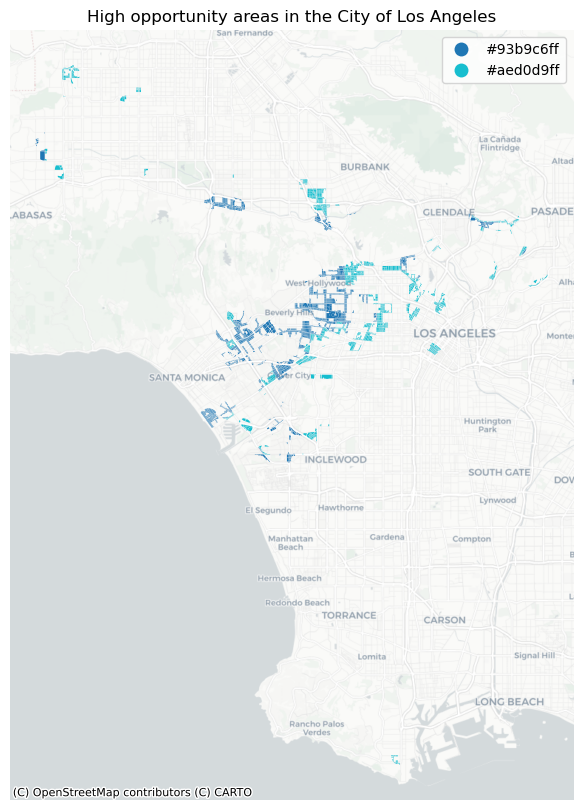

In [67]:
#plotting to check
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))


#adding colour to the plot
TOC_A.plot(
            ax=ax,   
            column = 'color_2',   # column that defines the color of the dota
            legend = True,     # add a legend        
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )


    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('High opportunity areas in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [68]:
#dissolve by oppcat (color_2) TO GET AREA OF TOC BY SF
#to get the area of each oppcat valye, lets dissolve and then calculate 
TOC_A = TOC_A.dissolve(by='color_2')

In [69]:
TOC_A.sample(2)

geometry FINALTIER  \
color_2                                                                  
#93b9c6ff  MULTIPOLYGON (((-13188120.450 4026678.193, -13...         2   
#aed0d9ff  MULTIPOLYGON (((-13203281.073 4052112.132, -13...         2   

             Shape_Leng    Shape__Are     Shape__Len    color_1  OBJECTID_1  \
color_2                                                                       
#93b9c6ff  2.290647e+06  1.256173e+08  843718.537556  #e487adff           1   
#aed0d9ff  2.290647e+06  1.256173e+08  843718.537556  #e487adff           1   

                  fips      cnty_nm  area_km2_2            oppcat  OBJECTID_2  
color_2                                                                        
#93b9c6ff  06037106641  Los Angeles  511.743823  Highest_Resource        1196  
#aed0d9ff  06037101122  Los Angeles  273.800812     High_Resource          61

In [70]:
#getting a column to calculate the area of each tier category
TOC_A['area_km2_2'] = TOC_A.area / 1000**2

In [71]:
TOC_A.sample(2)

geometry FINALTIER  \
color_2                                                                  
#aed0d9ff  MULTIPOLYGON (((-13203281.073 4052112.132, -13...         2   
#93b9c6ff  MULTIPOLYGON (((-13188120.450 4026678.193, -13...         2   

             Shape_Leng    Shape__Are     Shape__Len    color_1  OBJECTID_1  \
color_2                                                                       
#aed0d9ff  2.290647e+06  1.256173e+08  843718.537556  #e487adff           1   
#93b9c6ff  2.290647e+06  1.256173e+08  843718.537556  #e487adff           1   

                  fips      cnty_nm  area_km2_2            oppcat  OBJECTID_2  
color_2                                                                        
#aed0d9ff  06037101122  Los Angeles   20.626881     High_Resource          61  
#93b9c6ff  06037106641  Los Angeles   23.141228  Highest_Resource        1196

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


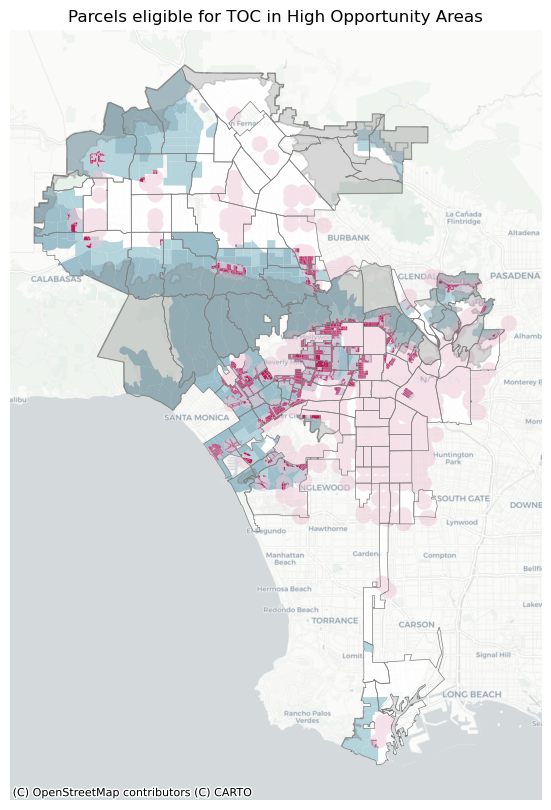

In [72]:
#plotting to check
#starting the plot
fig, ax = plt.subplots(figsize=(10,10))


#adding colour to the plot

citytracts.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            color = citytracts['color'], #to color according to the TCAC values, based on a new column
            legend = True,     # add a legend        
            alpha = 0.9,
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

TOC_dis.plot(
            ax=ax,   
            column = 'FINALTIER',   # column that defines the color of the dota
            color = '#eec8d7ff', #to color according to the TOC values, based on a new column       
            legend = True,     # add a legend        
            alpha = 0.5,
    
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )




TOC_A.plot(
            ax=ax,   
            legend = True,     # add a legend        
            color = '#bc1d59ff',
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

fire_la.plot(
            ax=ax, 
            color = 'grey',
            alpha = 0.3,
            edgecolor = 'grey',
)

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.5,
            )
    
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Parcels eligible for TOC in High Opportunity Areas')

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)